# Simulating Spurious Association
This is a simple simulation of spurious associations based on the book [Statistical Rethinking by Richard McElreath](https://xcelab.net/rm/statistical-rethinking/) chapter 5.1.

In [1]:
from scipy import stats
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns
import pandas as pd
from causalgraphicalmodels import CausalGraphicalModel

The purpose of this simulation is to show that with a mutiple regression model it's possible to spot spurious associations.

Below `x_real` which is a truly causal predictor that influences both `y` and `x_spur`.

In [2]:
SAMP_SIZE = 10000 # size of sample

# all standardised -> mean=0, std=1
x_real = stats.norm.rvs(size=SAMP_SIZE)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)

# creating a pandas dataframe
d = {'x_real': x_real,
    'x_spur': x_spur,
    'y': y}
df = pd.DataFrame(data=d)
df.head()

,x_real,x_spur,y
0,0.095799,0.728446,1.529476
1,-0.921392,-1.090349,-0.709328
2,1.517074,-0.747889,2.619533
3,0.405690,0.069306,1.337669
4,0.022239,0.171597,-0.135914


In [3]:
df.describe()

,x_real,x_spur,y
count,10000.000000,10000.000000,10000.000000
mean,0.008809,0.007498,0.011530
std,0.992138,1.394158,1.413119
min,-3.700436,-5.904631,-5.124304
25%,-0.662937,-0.940528,-0.936480
50%,0.000533,-0.002539,0.025768
75%,0.669212,0.936875,0.958032
max,4.137479,5.341581,6.054162


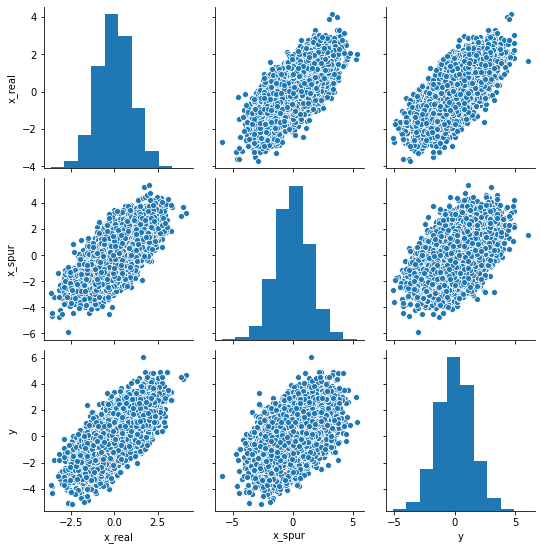

In [4]:
sns.pairplot(data=df)

We can notice by the pairplot above that `x_real` and `x_spur` seem be quite correlated to `y`.
<br>
<br>
The same can be seen on the correlation matrix bellow. However it's important to observe that the correlation between `x_spur` and `x_real` is quite high (as expected).

In [5]:
df.corr()

,x_real,x_spur,y
x_real,1.000000,0.706837,0.703859
x_spur,0.706837,1.000000,0.501307
y,0.703859,0.501307,1.000000


In [6]:
with pm.Model() as spur_t:
    a = pm.Normal('a', 0, 1)
    b = pm.Normal('b', 0, 1)
    c = pm.Normal('c', 0, 1)
    mu = pm.Deterministic('mu', a + b*x_real + c*x_spur)
    sigma = pm.Exponential('sigma', 1)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=y)
    
    spur_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1917.29draws/s]


/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

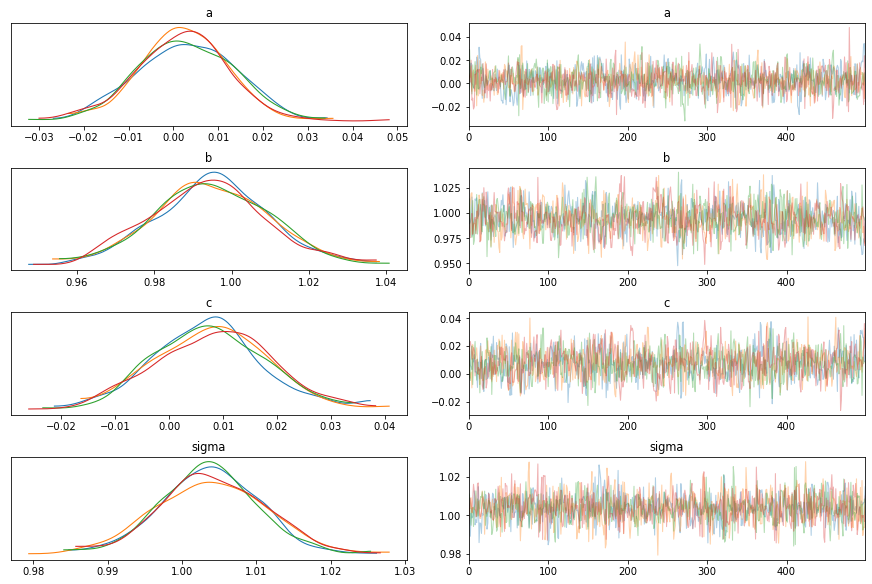

In [7]:
varnames = ['~mu']
az.plot_trace(spur_trace, var_names=varnames)

In [8]:
az.summary(spur_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,0.00,0.01,-0.02,0.02
b,0.99,0.01,0.97,1.02
c,0.01,0.01,-0.01,0.03
sigma,1.00,0.01,0.99,1.02


By using a mutiple regression we can spot that `x_spur`, is a spurious association to the variable `y` as its coeficient `c` is close to `0` with probability of both sides of `0` which means it does not explain the model.
<br>
<br>
It's interesting to notice that the value of `a` is also close to `0`, this is because the data is standardised (mean=0, std=1). 
<br>
<br>
We can represent the causal relationship with the following DAG(Directed Acyclic Graph):

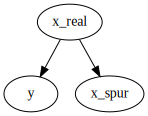

In [9]:
assoc = CausalGraphicalModel(
    nodes=["x_real", "x_spur", "y"], edges=[("x_real", "x_spur"), ("x_real", "y")]
)

assoc.draw()

In [10]:
%load_ext watermark
%watermark -iv -v -nuw

pymc3   3.8
arviz   0.10.0
seaborn 0.10.1
pandas  1.1.1
last updated: Fri Oct 30 2020 

CPython 3.7.7
IPython 7.17.0
watermark 2.0.2
